In [15]:
# only used for the Jupyter Notebook version:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [29]:
"""
Module used for creating drift
correction factor histograms type plots
=======================================
:Author: Jennifer Holden
:Created: 2022-05-20
"""

import os
import sys
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.legend import Legend
import math
import xarray as xr

##############################################################################
# The central plot
##############################################################################

def plot_hist2d(df, ax, data_bins, val, cmap='viridis'):
    """Creates the central portion of the alpha histogram plot"""

    counts, xedges, yedges, hist = ax.hist2d(
        df.alpha_real.values,
        df.alpha_imag.values,
        cmin=1,
        bins=data_bins,
        cmap=cm.get_cmap(cmap),
    )

    # add some extras to the central plot
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim([-1*val, val])
    ax.set_ylim([-1*val, val])
    ax.set_yticklabels([])

    return counts, xedges, yedges, hist


def plot_hexbin(df, ax, data_bins, val, cmap='viridis'):
    """ Creates an alternate version of the central plot
    which uses a hexbin plot instead of the regular 2dhist.
    In this case, the number of hexbins is chosen as the
    length of data_bins """
    hex = ax.hexbin(df.alpha_real.values,
                    df.alpha_imag.values,
                    gridsize=len(data_bins),
                    mincnt=1,
                    cmap=cm.get_cmap(cmap))

    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim([-1*val, val])
    ax.set_ylim([-1*val, val])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return hex, cmap


def add_stats_to_2dhist(ax, mean, std):
    """ Helper function that adds a red dot for the mean and an orange
    box for the standard deviation to the central histogram """

    # add the orange box
    srt = mean['alpha_real'] + std['alpha_real']
    srb = mean['alpha_real'] - std['alpha_real']
    sit = mean['alpha_imag'] + std['alpha_imag']
    sib = mean['alpha_imag'] - std['alpha_imag']

    x = [srb, srt, srt, srb, srb]
    y = [sit, sit, sib, sib, sit]
    ax.plot(x, y, color='orange', alpha=1, linewidth=2)

    # add the red dot for the means
    ax.plot(mean['alpha_real'],
            mean['alpha_imag'],
            'o', color='red',
            markersize=8)

    # add a black cross to highlight (0, 0)
    kwargs = {'color': 'grey', 'linewidth': 1, 'linestyle': '--', 'zorder': -1}
    ax.axhline(y=0, **kwargs)
    ax.axvline(x=0, **kwargs)


##############################################################################
# The 1d histogram plots
##############################################################################

def plot_axis_hist(df,
                   ax_hist,
                   var,
                   data_bins,
                   val,
                   counts1d,
                   cmap='viridis'):
    """ Creates the 1d histogram plots used on the top and right hand
    side of the central figure """

    # define the variable specific parameters
    valuesdict = {
        'alpha_real': {
            'xvals': df.alpha_real.values,
            'orientation': 'vertical',
            'xlab': (r'Re ($\alpha$)'),
            'ylab': '',
            'xlims': [-val, val],
            'ylims': [counts1d['min_counts'], counts1d['max_counts_plot']],
            'counts_axis': 'y',
        },
        'alpha_imag': {
            'xvals': df.alpha_imag.values,
            'orientation': 'horizontal',
            'xlab': '',
            'ylab': (r'Im ($\alpha$)'),
            'xlims': [counts1d['min_counts'], counts1d['max_counts_plot']],
            'ylims': [-val, val],
            'counts_axis': 'x',
        }
    }

    # create the plot
    axis_hist = ax_hist.hist(
        valuesdict[var]['xvals'],
        orientation=valuesdict[var]['orientation'],
        bins=data_bins,
        histtype='stepfilled',
        alpha=1,
        edgecolor='black'
    )

    # set the color of the 1d histograms based off the
    # colormap used for the 2dhist
    colormap = cm.get_cmap(cmap)
    color = colormap(np.nanmin(axis_hist[0]))
    plt.setp(axis_hist[2], 'facecolor', color)

    # add the grid, axis labels and adjust the plot limits
    ax_hist.grid(True, linestyle='--', alpha=0.5)
    ax_hist.set_ylabel(valuesdict[var]['ylab'])
    ax_hist.set_xlabel(valuesdict[var]['xlab'])
    ax_hist.set_xlim(valuesdict[var]['xlims'])
    ax_hist.set_ylim(valuesdict[var]['ylims'])
    ax_hist.xaxis.tick_top()
    ax_hist.xaxis.set_label_position('top')
    # set the number of counts labels to 4 so that they will be the same
    # on both axis. Remove the first and last ticks by pruning both.
    plt.locator_params(axis=valuesdict[var]['counts_axis'],
                       prune='both', nbins=4)

    # Move the axis ticks/labels to the right of the plot for alpha_imag.
    if var == 'alpha_imag':
        ax_hist.yaxis.tick_right()
        ax_hist.yaxis.set_label_position('right')


def add_stats_to_1dhist(ax, var, mean, std, counts1d):
    """ Adds a red bar to the 1d histogram plot at the mean alpha value
    and a filled orange range showing one standard deviation. """

    hist_max = counts1d['max_counts_plot']
    hist_min = counts1d['min_counts']
    std_top = mean[var] + std[var]
    std_bot = mean[var] - std[var]

    # variable specific values
    valuesdict = {
        'alpha_real': {'x_mean': [mean[var], mean[var]],
                       'xst': [std_top, std_top],
                       'xsb': [std_bot, std_bot],
                       'y_mean': [hist_min, hist_max],
                       'yst': [hist_min, hist_max],
                       'ysb': [hist_min, hist_max],
                       'fill_ticks': ax.get_yticks().tolist()},
        'alpha_imag': {'x_mean': [hist_min, hist_max],
                       'xst': [hist_min, hist_max],
                       'xsb': [hist_min, hist_max],
                       'y_mean': [mean[var], mean[var]],
                       'yst': [std_top, std_top],
                       'ysb': [std_bot, std_bot],
                       'fill_ticks': ax.get_xticks().tolist()}
    }

    # add a red line for the mean
    ax.plot(valuesdict[var]['x_mean'],
            valuesdict[var]['y_mean'],
            color='red',
            label='mean')

    # add orange lines for one standard deviation values
    ax.plot(valuesdict[var]['xst'],
            valuesdict[var]['yst'],
            color='orange',
            label='std',
            zorder=-1)
    ax.plot(valuesdict[var]['xsb'],
            valuesdict[var]['ysb'],
            color='orange',
            zorder=-1)
    handles, labels = ax.get_legend_handles_labels()

    # fill the area between the 1std bars
    kwargs = {'color': 'orange', 'alpha': 0.05, 'zorder': -1}
    if var == 'alpha_real':
        ax.fill_betweenx([hist_min, hist_max], std_bot, std_top, **kwargs)
    elif var == 'alpha_imag':
        ax.fill_between([hist_min, hist_max], std_bot, std_top, **kwargs)

    return handles, labels


##############################################################################
# helper functions
##############################################################################

def calculate_stats(ds):
    """
    Calculates the mean and standard devation of the alpha values as well
    as the drifter and ocean speeds. If there is atmospheric data present,
    atmos speed is calculated as well. Also sets up some strings based on
    the stats values to be used when creating the legend
    """

    # calculate the speeds
    df = pd.DataFrame({
        'alpha_real': ds.alpha_real.values,
        'alpha_imag': ds.alpha_imag.values,
        'drifter_speed': np.sqrt(ds.ueast_drifter**2 + ds.vnorth_drifter**2),
        'ocean_speed': np.sqrt(ds.ueast_ocean**2 + ds.vnorth_ocean**2)})

    # assuming atmos data is present, calculate the atmos speed as well,
    # then filter values where atmos speed is less than 1 m/s
    if ('ueast_atmos' in ds.keys()) and ('vnorth_atmos' in ds.keys()):
        df['atmos_speed'] = np.sqrt(ds.ueast_atmos**2 + ds.vnorth_atmos**2)
        df = df[df.atmos_speed > 1]

    mean = df[['alpha_real', 'alpha_imag']].mean()
    std = df[['alpha_real', 'alpha_imag']].std()
    alpha_char = chr(945)
    strs = {
        'mean_alpha_real':
            'mean Re (' + alpha_char + '): {0:.3f}'.format(mean['alpha_real']),
        'mean_alpha_imag':
            'mean Im (' + alpha_char + '): {0:.3f}'.format(mean['alpha_imag']),
        'std_alpha_real':
            'std Re (' + alpha_char + '): {0:.3f}'.format(std['alpha_real']),
        'std_alpha_imag':
            'std Im (' + alpha_char + '): {0:.3f}'.format(std['alpha_imag']),
    }
    return df, mean, std, strs


def grab_bin_parameters(df, num_data_bins=100, val=None):
    """
    Helper function that finds the maximum alpha value between alpha_real
    and alpha_imag so that it can be used as axis limits when plotting.
    Then, defines the data bins to use for the histogram plots based on
    the maximum alpha value.
    """
    if val is None:
        alldata = list(df.alpha_real.values) + list(df.alpha_imag.values)
        val = np.nanmax(
            [np.abs(np.nanmin(alldata)), np.abs(np.nanmax(alldata))]
        )
    data_bins = np.linspace(-1*val, val, num=num_data_bins)

    return val, data_bins


def add_legend(ax1, real_handles, imag_handles, mean, std):
    """ Adds two stats legends to the central axis """
    
    alpha_char = chr(945)
    
    # alpha_real legend
    leg_real = ax1.legend(real_handles,
                          ['mean: {0:.3f}'.format(mean['alpha_real']),
                           'std: {0:.3f}'.format(std['alpha_real'])],
                          frameon=False,
                          loc='lower left',
                          handlelength=1,
                          framealpha=0,
                          handleheight=0.9,
                          title='Re (' + alpha_char + ')')
    leg_real._legend_box.align = "left"

    # alpha_imag legend
    leg_imag = Legend(ax1,
                      imag_handles,
                      ['mean: {0:.3f}'.format(mean['alpha_imag']),
                       'std: {0:.3f}'.format(std['alpha_imag'])],
                      frameon=False,
                      loc='upper right',
                      handlelength=1,
                      framealpha=0,
                      handleheight=0.9,
                      title='Im (' + alpha_char + ')')
    leg_imag._legend_box.align = "left"
    ax1.add_artist(leg_imag)


def grab_1d_counts(df, data_bins):
    """
    Determines the maximum number of counts per bin including values
    from both alpha_real and alpha_imag. This value is used to set the
    common y-axis limits for the 1d histogram plots
    """

    H_real, edges_real = np.histogram(df['alpha_real'].values,
                                      bins=data_bins)
    H_imag, edges_imag = np.histogram(df['alpha_imag'].values,
                                      bins=data_bins)

    # find the max count for alpha_real and alpha_imag, then round up to
    # the nearest 5
    mreal = np.amax(H_real, axis=0)
    mimag = np.amax(H_imag, axis=0)
    max_counts_5 = math.ceil(5*math.ceil(round(np.nanmax([mreal, mimag]))/5))

    # add the various counts to a dictionary for later use
    counts1d = {
        'min_counts': round(np.nanmin([np.amin(H_real, axis=0),
                                       np.amin(H_imag, axis=0)])),
        'max_counts': round(np.nanmax([np.amax(H_real, axis=0),
                                       np.amax(H_imag, axis=0)])),
        'min_counts_real': np.amin(H_real, axis=0),
        'max_counts_real': np.amax(H_real, axis=0),
        'min_counts_imag': np.amin(H_imag, axis=0),
        'max_counts_imag': np.amax(H_imag, axis=0),
        'max_counts_plot': round(np.nanmax([np.amax(H_real, axis=0),
                                            np.amax(H_imag, axis=0)])) * 1.10,
        'max_counts_5': max_counts_5,
    }

    # make sure that there is at least a small buffer between the
    # histogram and the top of the plot
    counts1d['max_counts_plot'] = counts1d['max_counts_5']
    max_imag = counts1d['max_counts_imag']
    max_real = counts1d['max_counts_real']
    if (np.abs(max_real - counts1d['max_counts_5']) < 5):
        if (np.abs(max_imag - counts1d['max_counts_5']) < 5):
            counts1d['max_counts_plot'] = counts1d['max_counts_5'] + 5

    return counts1d


def add_colorbar(hist, fig, cbar_ax, cmap='viridis'):
    """ Create a colorbar on the left hand side of the plot """

    # Add the colorbar
    cbar = fig.colorbar(
        hist,
        cax=cbar_ax,
        orientation='vertical',
        ticklocation='left',
        cmap=cm.get_cmap(cmap),
        ticks=matplotlib.ticker.MaxNLocator(integer=True)
    )

##############################################################################
# The workflow function
##############################################################################

def plot_histogram(*, ds, plot_dir, cmap='viridis'):
    """
    Creates a histogram plot for each drifter exploring the alpha values.

    Parameters
    ----------
    ds : xr.Dataset
        xarray dataset containing output from a drift correction factor
        experiment (required)
    plot_dir : str
        full path to folder where plots will be generated (required)
    cmap : str
        optional matplotlib colormap name (ex: 'RdBu_r', 'viridis',
        'Blues', etc).

    Returns
    -------
    fig : figure
        current matplotlib figure
    """

    # do not try to create the alpha histogram plot for data that was
    # not created using a wind component (the output files will not
    # contain alpha values in this case).
    if ('alpha_real' not in ds.keys()) or ('alpha_imag' not in ds.keys()):
        print('...failed to create histogram plot - plot not relevant '
                    + 'for correction factor output created without '
                    + 'atmospheric contributions.')
        return

    # do not try to create the alpha histogram plot for data with only
    # one measurement.
    if len(ds.alpha_real.values) < 2:
        print('...failed to create histogram plot - drift correction '
                    + 'factor output only contains one measurement.')
        return

    # Assume that the user is ok with the data in plot_dir being overwritten.
    if plot_dir:
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
    else:
        sys.exit('...failed to created histogram plot - the user must '
                 + 'provide plot_dir (full path to the directory where '
                 + 'the plots will be generated)')

    print('...creating histogram plot')

    # calculate some stats and filter out any data
    # where the atmos speed is less than 1 m/s
    df, mean, std, strs = calculate_stats(ds)

    # create the figure
    fig = plt.figure(1, figsize=(8, 7.5))

    # Set up the grid spacing including two extra columns with small
    # thickness values for extra spacing between the three horizontal axis.
    gs = gridspec.GridSpec(2, 5,
                           height_ratios=[0.2, 1],
                           width_ratios=[0.07, 0.005, 1, 0.005, 0.2])
    gs.update(left=0.05, right=0.95, bottom=0.08,
              top=0.93, wspace=0.03, hspace=0.03)

    # determine which plot extremes and bins to use
    val, data_bins = grab_bin_parameters(df, num_data_bins=51)
    # grab the maximum number of counts per bin across both alpha_real
    # and alpha_imag histograms to use when setting the axis of the 1d
    # histograms so that they will be the same
    counts1d = grab_1d_counts(df, data_bins)

    # --------------------------------------------------------
    # The 2d histogram goes in the center of the figure
    # --------------------------------------------------------
    ax1 = plt.subplot(gs[1, 2])
    counts, xedges, yedges, hist = plot_hist2d(
        df, ax1, data_bins, val, cmap=cmap
    )
    # add the red dot and orange box:
    add_stats_to_2dhist(ax1, mean, std)

    # --------------------------------------------------------
    # Place the colorbar on the left hand side of the plot
    # --------------------------------------------------------
    cbax = plt.subplot(gs[1, 0])
    add_colorbar(hist, fig, cbax, cmap=cmap)

    # --------------------------------------------------------
    # the alpha_imag hist goes on the right
    # --------------------------------------------------------
    ax1v = plt.subplot(gs[1, 4])
    plot_axis_hist(
        df, ax1v, 'alpha_imag', data_bins, val, counts1d, cmap=cmap
    )
    # add the red and orange horizontal lines
    imag_handles, imag_labels = add_stats_to_1dhist(
        ax1v, 'alpha_imag', mean, std, counts1d
    )

    # --------------------------------------------------------
    # the alpha_real hist goes on the top this time
    # --------------------------------------------------------
    ax1h = plt.subplot(gs[0, 2])
    plot_axis_hist(
        df, ax1h, 'alpha_real', data_bins, val, counts1d, cmap=cmap
    )
    # add the red and orange vertical lines
    real_handles, real_labels = add_stats_to_1dhist(
        ax1h, 'alpha_real', mean, std, counts1d
    )

    # --------------------------------------------------------
    # Add a legend or a text box with stats
    # --------------------------------------------------------
    add_legend(ax1, real_handles, imag_handles, mean, std)
    ax1.text(0.05, 0.95,
             str(ds.obs_buoyid),
             transform=ax1.transAxes,
             verticalalignment='top')

    # --------------------------------------------------------
    # save and close
    # --------------------------------------------------------
    savestr = 'histogram_{}.png'.format(ds.obs_buoyid)
    fig.savefig(os.path.join(plot_dir, savestr),
                bbox_inches='tight',
                transparent=False)

    return fig

    plt.show()

In [30]:
#data_dir = '/gpfs/fs4/dfo/dpnm/dfo_dpnm/jeh326/projects/DriftCorrectionFactor/DCF_vis-framework/plotting-input/'
data_dir = 'C:/Users/HoldenJe/Drift/projects/DriftCorrectionFactor/DCF_vis/dcf_histogram/20220615/dcf_input_data'
#data_dir = 'C:/Users/HoldenJe/Drift/projects/DriftCorrectionFactor/DriftCorrectionFactor_sample_output/output'
#plot_dir = '/gpfs/fs4/dfo/dpnm/dfo_dpnm/jeh326/projects/DriftCorrectionFactor/DCF_vis-framework/plots/histograms/20220628/'
plot_dir = 'C:/Users/HoldenJe/Drift/projects/DriftCorrectionFactor/DCF_vis/dcf_histogram/20220628/'
sample_file = os.path.join(data_dir, 'correction-factor_1001300434064148020_aggregated.nc')

...creating histogram plot


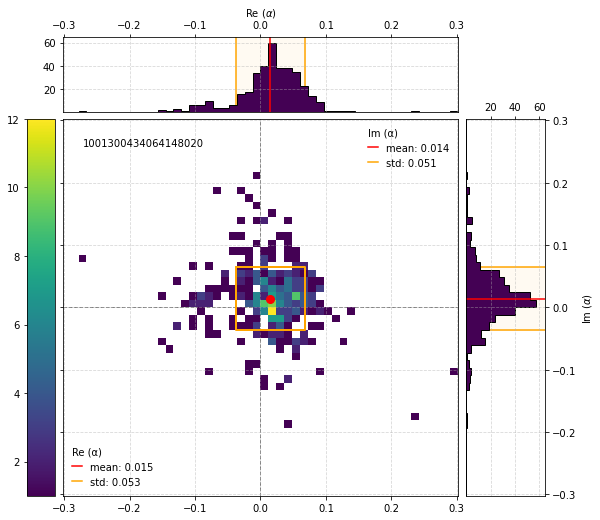

In [32]:
files = glob.glob(os.path.join(data_dir, '*.nc'))

'''
for filename in files:
    with xr.open_dataset(filename) as ds:
        plot_histogram(ds=ds, plot_dir=plot_dir)
'''

with xr.open_dataset(sample_file) as ds:
    plot_histogram(ds=ds, plot_dir=plot_dir)
